In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))

import galileo as gal
import huygens as huy

# Load annotations

In [9]:
ccle_genex = pd.read_hdf(
    "../../data/processed/ccle/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf", key="ccle_genex")
ccle_transcripts = pd.read_hdf("../../data/processed/ccle/CCLE_RNAseq_rsem_transcripts_tpm_20180929.hdf",
                               key="ccle_transcripts")
exonusage = pd.read_hdf(
    "../../data/processed/ccle/CCLE_RNAseq_ExonUsageRatio_20180929.hdf", key="exonusage")

ms_prot = pd.read_hdf("../../data/processed/ccle/ms_prot.h5", key="ms_prot")
rppa = pd.read_hdf(
    "../../data/processed/ccle/CCLE_RPPA_20181003.hdf", key="rppa")

primary_logfold = pd.read_hdf(
    "../../data/processed/depmap/primary_logfold.h5", key="primary_logfold")
secondary_logfold = pd.read_hdf(
    "../../data/processed/depmap/secondary_logfold.h5", key="secondary_logfold")

In [58]:
msi = pd.read_excel("../data/external/ccle2/41586_2019_1186_MOESM10_ESM.xlsx",sheet_name="MSI calls")
msi = msi.set_index("depMapID")
msi["GDSC_msi"] = msi["GDSC.msi.call"].replace({"MSI-H":True,"MSS/MSI-L":False})
msi["CCLE_msi"] = msi["CCLE.MSI.call"].replace({"inferred-MSI":True,"inferred-MSS":False,"undetermined":np.nan})

msi = msi.dropna(subset=["GDSC_msi","CCLE_msi"],how="all")

msi["MSI"] = msi["GDSC_msi"] | msi["CCLE_msi"]
name_map = dict(zip(msi["CCLE_ID"],msi.index))
name_map["HS294T_SKIN"] = "ACH-000014"

# Compute differences

In [ ]:
msi_prot_diffs = gal.mat_mwus_naive(ms_prot,msi["MSI"],pbar=True)
msi_prot_diffs.to_csv("../data/intermediate/msi_prot_diffs.txt",sep="\t")

msi_exon_diffs = gal.mat_mwus_naive(exonusage,msi["MSI"],pbar=True,effect="mean")
msi_exon_diffs.to_csv("../data/intermediate/msi_exon_diffs.txt",sep="\t")

# Mutations

In [3]:
msi_prot_diffs = pd.read_csv("../data/intermediate/msi_prot_diffs.txt",sep="\t")
msi_exon_diffs = pd.read_csv("../data/intermediate/msi_exon_diffs.txt",sep="\t",index_col=0)

## Storage bucket info

In [16]:
ccle_samples = pd.read_csv("../data/raw/fullccle_samples.csv")
wgs_samples = ccle_samples[ccle_samples["datatype"]=="wgs"]
wgs_samples = wgs_samples.sort_values(by=["arxspan_id","version","size"])
wgs_samples = wgs_samples.drop_duplicates(subset=["arxspan_id"],keep="first")

## Gene intervals

In [68]:
msi_exons = msi_exon_diffs.copy()[msi_exon_diffs["qval"]>=4]

msi_exons["gene"] = msi_exons.index.map(lambda x: x.split("_")[-1])
msi_exons["exon_chrom"] = msi_exons.index.map(lambda x: x.split("_")[-4][3:])
msi_exons["exon_start"] = msi_exons.index.map(lambda x: x.split("_")[-3])
msi_exons["exon_end"] = msi_exons.index.map(lambda x: x.split("_")[-2])

msi_exons["exon"] = msi_exons["exon_chrom"] + "_" + msi_exons["exon_start"] + "_" + msi_exons["exon_end"]

msi_exons["exon_start"] = msi_exons["exon_start"].astype(int)
msi_exons["exon_end"] = msi_exons["exon_end"].astype(int)

msi_exons = msi_exons.drop_duplicates(subset=["exon"])

In [69]:
def get_exon_bounds(row,padding=1000):
    
    if row["exon_start"] < row["exon_end"]:
        row["bound_start"] = row["exon_start"]-padding
        row["bound_end"] = row["exon_end"]+padding
    
    elif row["exon_start"] > row["exon_end"]:
        row["bound_start"] = row["exon_end"]-padding
        row["bound_end"] = row["exon_start"]+padding
        
    return row
    
msi_exons = msi_exons.apply(get_exon_bounds,axis=1)

In [70]:
msi_exons[["exon_chrom","bound_start","bound_end"]].to_csv("../scripts/MSI_exon_bounds.bed",sep="\t",header=False,index=False)
msi_exons[["exon_chrom","bound_start","bound_end"]].to_csv("../data/raw/MSI_exon_bounds.bed",sep="\t",header=False,index=False)

In [71]:
with open("../scripts/wgs_paths.txt","w") as f:
    for bam_path in list(wgs_samples["internal_bam_filepath"]):
        f.write(bam_path+"\n")
        
with open("../scripts/wgs_ids.txt","w") as f:
    for bam_path in list(wgs_samples["arxspan_id"]):
        f.write(bam_path+"\n")

In [72]:
with open("../scripts/7_fetch-msi-slices.sh", "w") as f:
    for bam_path, ach_id in zip(list(wgs_samples["internal_bam_filepath"]), list(wgs_samples["arxspan_id"])):

        f.write("export GCS_OAUTH_TOKEN=$(gcloud auth application-default print-access-token) && samtools view -b -h -M -L ../data/raw/MSI_exon_bounds.bed {} > ../data/raw/WGS_slices/{}.bam\n".format(bam_path, ach_id))

## Load mutations

In [25]:
msi_exon_muts = pd.read_csv("../data/intermediate/msi_exon_calls_filtered.txt",
                            sep="\t",
                            names=["chrom","pos","sample","ref","alt","genotype"]
                           )

wgs_sample_ids = pd.read_csv("../scripts/wgs_ids_samples.txt",sep="\t",names=["ach_id","sample_name","cn_bi"])
wgs_sample_map = dict(zip(wgs_sample_ids["sample_name"],wgs_sample_ids["ach_id"]))
wgs_sample_map["Detroit 562"] = "ACH-000207"

msi_exon_muts["ach_id"] = msi_exon_muts["sample"].apply(lambda x: wgs_sample_map[x])

In [28]:
msi_exon_muts["mut_site"] = msi_exon_muts["chrom"] + "_" + msi_exon_muts["pos"].astype(str)
msi_exon_muts["value"] = 1
msi_exon_mut_mat = pd.pivot_table(msi_exon_muts, values="value", index=[
                            "ach_id"], columns="mut_site", fill_value=0)

In [120]:
res = gal.mat_fishers(msi["MSI"],msi_exon_mut_mat)
msi_muts = res[(res["oddsr"]>=8)|(res["oddsr"]<=1/8)]

../../galileo/galileo/categorical_categorical.py:241: RuntimeWarning: divide by zero encountered in true_divide
  oddsrs = (AB/Ab)/(aB/ab)
../../galileo/galileo/categorical_categorical.py:241: RuntimeWarning: invalid value encountered in true_divide
  oddsrs = (AB/Ab)/(aB/ab)


In [151]:
res = gal.mat_corrs_nan(avana["WRN_7486"],ms_prot)

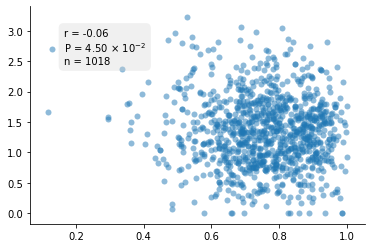

In [15]:
huy.regression(exonusage["UBAP2L_5p_chr1_154242676_154243329_ENSG00000143569.14"],
              ccle_transcripts["UBAP2L_ENST00000495676.1"]
             )

In [16]:
corrs = gal.mat_corrs_nan(exonusage["UBAP2L_5p_chr1_154242676_154243329_ENSG00000143569.14"],
              ccle_transcripts)

In [183]:
msi_exons[msi_exons.index.map(lambda x: "RAB3" in x)]

,corr,pval,pos_n,neg_n,qval,gene,exon_chrom,exon_start,exon_end,exon,bound_start,bound_end
RAB3GAP2_5p_chr1_220369740_220369592_ENSG00000118873.11,-0.633488,15.526574,51.0,890.0,11.867673,ENSG00000118873.11,1,220369740,220369592,1_220369740_220369592,220368592,220370740
